<a href="https://colab.research.google.com/github/Jake-LJH/ML/blob/main/kings_county.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PART B: REGRESSION - Kings County

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

The Goal is to predict the house price

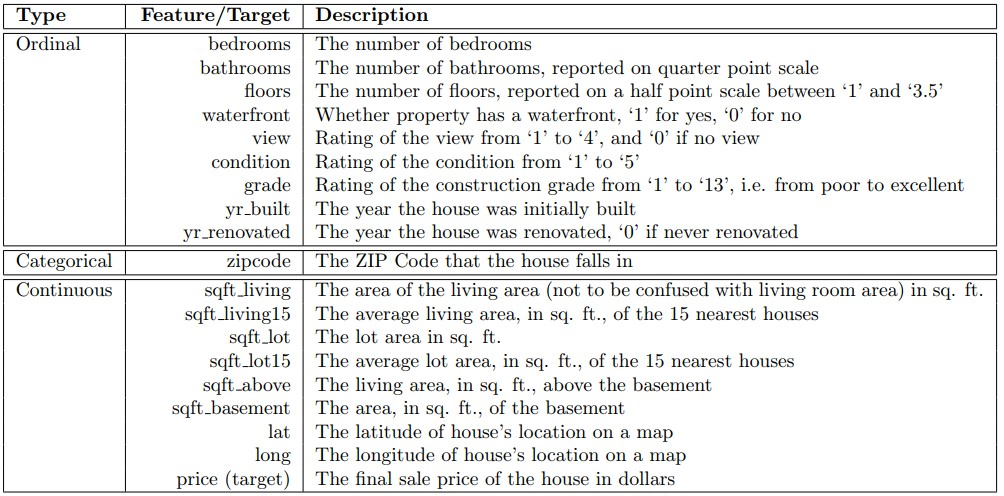

In [1]:
import numpy as np
import pandas as pd


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_roc_curve


from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
file = '/content/kc_house_data.csv'
data = pd.read_csv(file)
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
print(data.isnull().sum())

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


In [4]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

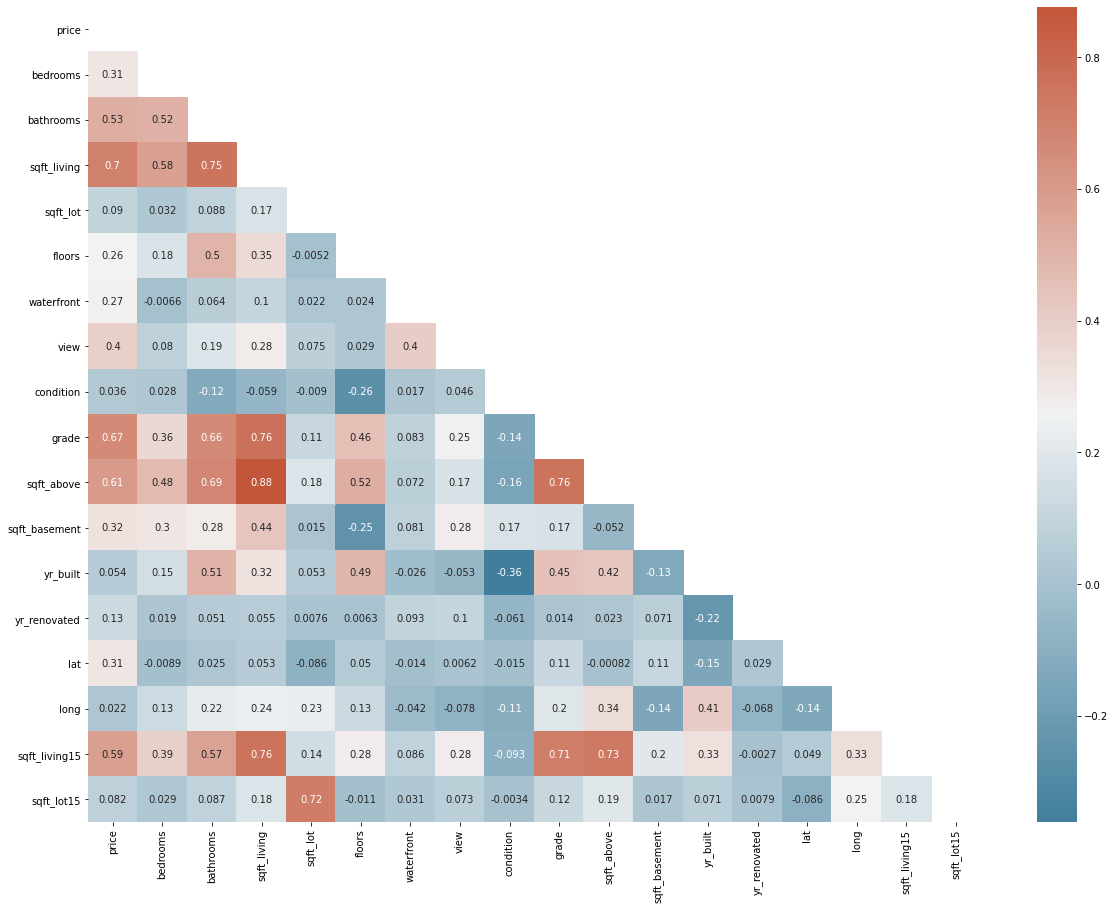

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualise data with correlation

# Dropping unwanted columns first
data = data.drop(['id','zipcode',], axis=1)
corr = data.corr()
fig, ax = plt.subplots(figsize=(20,15))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, annot=True, cmap=cmap, mask = mask)
plt.show()

# Visual Data Analysis

Setting the price as the target goal for prediction. I would want to see which feature has a posiitve and strong relationship with the price:

1. bathrooms
2. sqft_lot
3. view
4. grade
5. sqft_above
6. sfft_living15

Some weaker relationship:
 
1. bedrooms
2. lat
3. sqft_basement

Some possible features to consider:
1. renovated
2. yr_since_built

In [4]:
# Add new features
data['renovated'] = np.where(data['yr_renovated'] == 0, 0,1)
data['year'] = data['date'].str[:4].apply(int)
data['yr_since_built'] = data['year'] - data['yr_built']
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,year,yr_since_built
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,0,2014,59
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,1,2014,63
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,0,2015,82
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,0,2014,49
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,0,2015,28


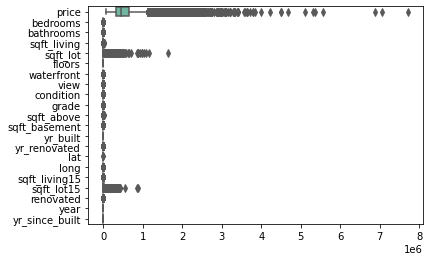

In [7]:
ax = sns.boxplot(data=data, orient="h", palette="Set2")

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            21613 non-null  object 
 1   price           21613 non-null  float64
 2   bedrooms        21613 non-null  int64  
 3   bathrooms       21613 non-null  float64
 4   sqft_living     21613 non-null  int64  
 5   sqft_lot        21613 non-null  int64  
 6   floors          21613 non-null  float64
 7   waterfront      21613 non-null  int64  
 8   view            21613 non-null  int64  
 9   condition       21613 non-null  int64  
 10  grade           21613 non-null  int64  
 11  sqft_above      21613 non-null  int64  
 12  sqft_basement   21613 non-null  int64  
 13  yr_built        21613 non-null  int64  
 14  yr_renovated    21613 non-null  int64  
 15  lat             21613 non-null  float64
 16  long            21613 non-null  float64
 17  sqft_living15   21613 non-null 

In [38]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,year,yr_since_built
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652,0.042289,2014.322954,43.317818
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631,0.201253,0.467616,29.375493
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,0.000000,2014.000000,-1.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000,0.000000,2014.000000,18.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000,0.000000,2014.000000,40.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,0.000000,2015.000000,63.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,1.000000,2015.000000,115.000000


In [39]:
corr_matrix = data.corr()
corr_matrix['price'].sort_values(ascending=False)

price             1.000000
sqft_living       0.702035
grade             0.667434
sqft_above        0.605567
sqft_living15     0.585379
bathrooms         0.525138
view              0.397293
sqft_basement     0.323816
bedrooms          0.308350
lat               0.307003
waterfront        0.266369
floors            0.256794
yr_renovated      0.126434
renovated         0.126092
sqft_lot          0.089661
sqft_lot15        0.082447
yr_built          0.054012
condition         0.036362
long              0.021626
year              0.003576
id               -0.016762
zipcode          -0.053203
yr_since_built   -0.053951
Name: price, dtype: float64

In [45]:
features = data.drop(['price','lat','long','date','year','id','zipcode',],axis=1)
target = data['price']
X = pd.DataFrame(data=features)
Y = pd.DataFrame(data=target)

In [46]:
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,renovated,yr_since_built
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,1340,5650,0,59
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,1690,7639,1,63
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,2720,8062,0,82
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,1360,5000,0,49
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,1800,7503,0,28


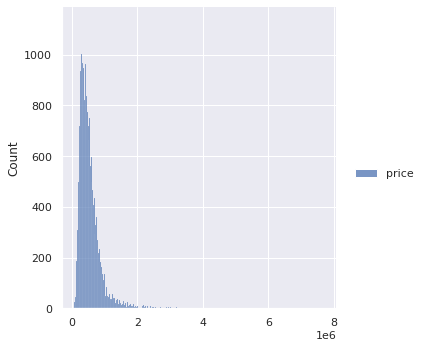

In [12]:
# Distribution of Target value
sns.set(rc={'figure.figsize':(20,15)})
sns.displot(Y)
plt.show()

# Comparing different scaler

MinMaxScaler, StandardScaler, RobustScaler

In [13]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

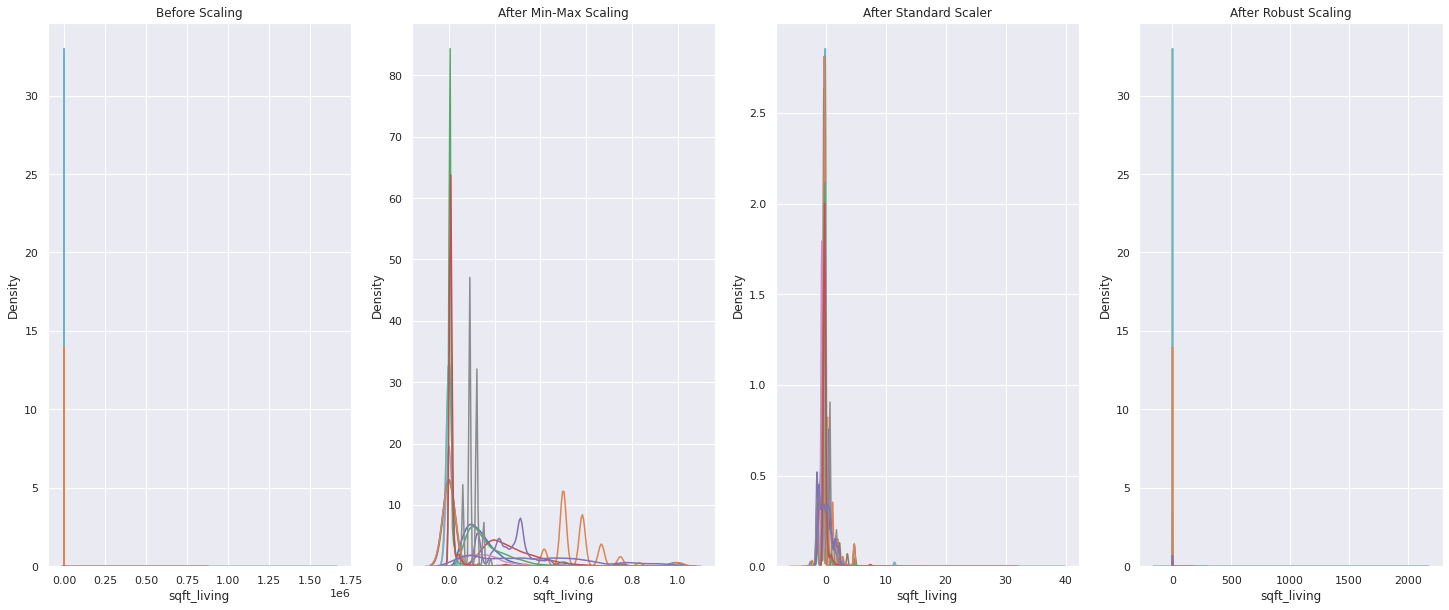

In [14]:
x = pd.DataFrame({
    'sqft_living': data.sqft_living,
    'grade': data.grade,
    'sqft_above': data.sqft_above,
    'sqft_living15' : data.sqft_living15,
    'bathrooms': data.bathrooms,
    'view' : data.view,
    'sqft_basement': data.sqft_basement,
    'bedrooms': data.bedrooms,
    'waterfront':data.waterfront,
    'floors':data.waterfront,
    'yr_renovated':data.yr_renovated,
    'renovated': data.renovated,
    'sqft_lot': data.sqft_lot,
    'sqft_lot15': data.sqft_lot15,
    'yr_since_built': data.yr_since_built

})

scaler = preprocessing.MinMaxScaler()
minmax_scaled_data = scaler.fit_transform(x)
minmax_scaled_data = pd.DataFrame(minmax_scaled_data, columns=['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'view','sqft_basement', 'bedrooms', 'waterfront','floors','yr_renovated','renovated','sqft_lot','sqft_lot15','yr_since_built'])

scaler = preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(x)
scaled_data = pd.DataFrame(scaled_data, columns=['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'view','sqft_basement', 'bedrooms', 'waterfront','floors','yr_renovated','renovated','sqft_lot','sqft_lot15','yr_since_built'])
    
scaler = preprocessing.RobustScaler()
robust_scaled_data = scaler.fit_transform(x)
robust_scaled_data = pd.DataFrame(robust_scaled_data, columns=['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'view', 'sqft_basement', 'bedrooms', 'waterfront','floors','yr_renovated','renovated','sqft_lot','sqft_lot15','yr_since_built'])


fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(25, 10))
ax1.set_title('Before Scaling')
sns.kdeplot(x['sqft_living'], ax=ax1)
sns.kdeplot(x['grade'], ax=ax1)
sns.kdeplot(x['sqft_above'], ax=ax1)
sns.kdeplot(x['sqft_living15'], ax=ax1)
sns.kdeplot(x['bathrooms'], ax=ax1)
sns.kdeplot(x['view'], ax=ax1)
sns.kdeplot(x['sqft_basement'], ax=ax1)
sns.kdeplot(x['bedrooms'], ax=ax1)
sns.kdeplot(x['waterfront'], ax=ax1)
sns.kdeplot(x['floors'], ax=ax1)
sns.kdeplot(x['yr_renovated'], ax=ax1)
sns.kdeplot(x['renovated'], ax=ax1)
sns.kdeplot(x['sqft_lot'], ax=ax1)
sns.kdeplot(x['sqft_lot15'], ax=ax1)
sns.kdeplot(x['yr_since_built'], ax=ax1)

ax2.set_title('After Min-Max Scaling')
sns.kdeplot(minmax_scaled_data['sqft_living'], ax=ax2)
sns.kdeplot(minmax_scaled_data['grade'], ax=ax2)
sns.kdeplot(minmax_scaled_data['sqft_above'], ax=ax2)
sns.kdeplot(minmax_scaled_data['sqft_living15'], ax=ax2)
sns.kdeplot(minmax_scaled_data['bathrooms'], ax=ax2)
sns.kdeplot(minmax_scaled_data['view'], ax=ax2)
sns.kdeplot(minmax_scaled_data['sqft_basement'], ax=ax2)
sns.kdeplot(minmax_scaled_data['bedrooms'], ax=ax2)
sns.kdeplot(minmax_scaled_data['waterfront'], ax=ax2)
sns.kdeplot(minmax_scaled_data['floors'], ax=ax2)
sns.kdeplot(minmax_scaled_data['yr_renovated'], ax=ax2)
sns.kdeplot(minmax_scaled_data['renovated'], ax=ax2)
sns.kdeplot(minmax_scaled_data['sqft_lot'], ax=ax2)
sns.kdeplot(minmax_scaled_data['sqft_lot15'], ax=ax2)
sns.kdeplot(minmax_scaled_data['yr_since_built'], ax=ax2)

ax3.set_title('After Standard Scaler')
sns.kdeplot(scaled_data['sqft_living'], ax=ax3)
sns.kdeplot(scaled_data['grade'], ax=ax3)
sns.kdeplot(scaled_data['sqft_above'], ax=ax3)
sns.kdeplot(scaled_data['sqft_living15'], ax=ax3)
sns.kdeplot(scaled_data['bathrooms'], ax=ax3)
sns.kdeplot(scaled_data['view'], ax=ax3)
sns.kdeplot(scaled_data['sqft_basement'], ax=ax3)
sns.kdeplot(scaled_data['bedrooms'], ax=ax3)
sns.kdeplot(scaled_data['waterfront'], ax=ax3)
sns.kdeplot(scaled_data['floors'], ax=ax3)
sns.kdeplot(scaled_data['yr_renovated'], ax=ax3)
sns.kdeplot(scaled_data['renovated'], ax=ax3)
sns.kdeplot(scaled_data['sqft_lot'], ax=ax3)
sns.kdeplot(scaled_data['sqft_lot15'], ax=ax3)
sns.kdeplot(scaled_data['yr_since_built'], ax=ax3)

ax4.set_title('After Robust Scaling')
sns.kdeplot(robust_scaled_data['sqft_living'], ax=ax4)
sns.kdeplot(robust_scaled_data['grade'], ax=ax4)
sns.kdeplot(robust_scaled_data['sqft_above'], ax=ax4)
sns.kdeplot(robust_scaled_data['sqft_living15'], ax=ax4)
sns.kdeplot(robust_scaled_data['bathrooms'], ax=ax4)
sns.kdeplot(robust_scaled_data['view'], ax=ax4)
sns.kdeplot(robust_scaled_data['sqft_basement'], ax=ax4)
sns.kdeplot(robust_scaled_data['bedrooms'], ax=ax4)
sns.kdeplot(robust_scaled_data['waterfront'], ax=ax4)
sns.kdeplot(robust_scaled_data['floors'], ax=ax4)
sns.kdeplot(robust_scaled_data['yr_renovated'], ax=ax4)
sns.kdeplot(robust_scaled_data['renovated'], ax=ax4)
sns.kdeplot(robust_scaled_data['sqft_lot'], ax=ax4)
sns.kdeplot(robust_scaled_data['sqft_lot15'], ax=ax4)
sns.kdeplot(robust_scaled_data['yr_since_built'], ax=ax4)
plt.show()

# Data Pre-processing

In [47]:
from sklearn.model_selection import train_test_split

X_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)


In [48]:
X.dtypes

bedrooms            int64
bathrooms         float64
sqft_living         int64
sqft_lot            int64
floors            float64
waterfront          int64
view                int64
condition           int64
grade               int64
sqft_above          int64
sqft_basement       int64
yr_built            int64
yr_renovated        int64
sqft_living15       int64
sqft_lot15          int64
renovated           int64
yr_since_built      int64
dtype: object

In [24]:
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

In [49]:
# Linear Regression
X1 = sm.add_constant(X_train)
ols = sm.OLS(y_train,X1)
lr = ols.fit()

selected_features = list(X.columns)
pmax = 1
while (len(selected_features)>0):
    p= []
    X_1 = X[selected_features]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(Y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = selected_features)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        selected_features.remove(feature_with_p_max)
    else:
        break  
        
print('The selected features are :', selected_features)

The selected features are : ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'renovated', 'yr_since_built']


In [50]:
print(model.pvalues)

const              5.477787e-14
bedrooms           3.070365e-85
bathrooms          7.369394e-38
sqft_living        0.000000e+00
floors             8.419597e-14
waterfront        7.685532e-213
view               6.741334e-80
condition          4.333927e-18
grade              0.000000e+00
sqft_above        3.433188e-108
sqft_basement      4.834103e-94
yr_built           1.798745e-13
yr_renovated       6.458508e-13
sqft_living15      7.511331e-13
sqft_lot15         4.186541e-23
renovated          7.663734e-13
yr_since_built     1.926435e-17
dtype: float64


# Hyper-parameter

In [ ]:
# XGboost
tuned_parameters = [{'max_depth': [5,10],'learning_rate':[0.001, 0.01, 0.1, 0.5], 'n_estimators': [100,150,200]}]
MSE_xgb = ['mean_squared_error(y_test,y_pred2)']
for value in MSE_xgb:
    regr = GridSearchCV(xgb.XGBRegressor(silent = True), tuned_parameters, cv=4)
    regr.fit(X_train, y_train)
    y_true, y_pred2 = y_test, regr.predict(x_test)
    
print('The best hyper-parameters for XGBBoost are: ',regr.best_params_)

In [ ]:
# AdaBoost
tuned_parameters = [{'learning_rate': [0.1,1,2,3,4,5], 'n_estimators': [100,200,300, 400, 500]}]
MSE_ada = ['mean_squared_error(y_test,y_pred3)']
for value in MSE_ada:
    adaregr = GridSearchCV(AdaBoostRegressor(), tuned_parameters, cv=4)
    adaregr.fit(X_train, y_train)
    y_true, y_pred3 = y_test, adaregr.predict(x_test)
    
print('The best hyper-parameters for AdaBoost are: ', adaregr.best_params_ )

In [ ]:
# Decision Tree
tuned_parameters = [{'max_depth': [1,2,3,4,5,10, 15, 20, 25, 50, 100,200]}]
MSE_dt = ['mean_squared_error(y_test,y_pred4)']
for value in MSE_dt:
    regressor_dt = GridSearchCV(DecisionTreeRegressor(), tuned_parameters, cv=4)
    regressor_dt.fit(X_train, y_train)
    y_true, y_pred4 = y_test, regressor_dt.predict(x_test)
    
print('The optimum max_depth for Decision Tree is: ', regressor_dt.best_params_ )

In [ ]:
# Random Forests
tuned_parameters = [{'max_depth': [5,10], 'n_estimators': [50, 100,150, 200, 250]}]
MSE_rf = ['mean_squared_error(y_test, y_pred5)']
for value in MSE_rf:
    regr_rf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=4)
    regr_rf.fit(X_train, y_train)
    y_true, y_pred5 = y_test, regr_rf.predict(x_test)
    
print('The best hyper-parameters for Random Forests are: ',regr_rf.best_params_)

In [23]:
scaler = preprocessing.StandardScaler()                         # Features Scaling is required for distance-based algorithms
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(x_test)

In [ ]:
# KNN
scaler = preprocessing.StandardScaler()                         # Features Scaling is required for distance-based algorithms
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(x_test)

tuned_parameters = [{'n_neighbors': [1,2,3,4,5,10,15,20], 'p': [1,2]}]
MSE_knn = ['mean_squared_error(y_test,y_pred)']
for i in MSE_knn:
    model = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=4)
    model.fit(X_train_scaled, y_train)
    y_true, y_pred6 = y_test, model.predict(X_test_scaled)
    
print('The best hyper-parameters for KNN are: ', model.best_params_)

In [ ]:
# SVM
tuned_parameters = [{'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale','auto']}]
MSE_svm = ['mean_squared_error(y_test,y_pred7)']
for value in MSE_svm:
    svr_regr = GridSearchCV(SVR(), tuned_parameters, cv=4)
    svr_regr.fit(X_train_scaled, y_train)
    y_true, y_pred7 = y_test, svr_regr.predict(X_test_scaled)
    
print('The best hyper-parameters for SVR are: ', svr_regr.best_params_)

In [24]:
# Build the models using the tuned hyper-parameters and fit

# Linear Regression
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)

# XGBoost
regr = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=200, random_state = 0, silent = True)
regr.fit(X_train, y_train)

# AdaBoost
adaregr = AdaBoostRegressor(random_state=0, learning_rate = 0.1, n_estimators=100)
adaregr.fit(X_train, y_train)

# Decision Tree
regressor_dt = DecisionTreeRegressor(random_state=0, max_depth = 5)
regressor_dt.fit(X_train,y_train)

# Random Forests
regr_rf = RandomForestRegressor(max_depth=10, random_state=0,
                             n_estimators=150)
regr_rf.fit(X_train, y_train)

# KNN
neigh = KNeighborsRegressor(n_neighbors = 5, metric = 'minkowski', p = 1)
neigh.fit(X_train_scaled, y_train)

# SVR
svr_regr = SVR(gamma='scale', kernel = 'linear')
svr_regr.fit(X_train_scaled, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [25]:
# Predict price using the models above
y_pred1 = regressor.predict(X_test_scaled)    # Linear regression
y_pred2 = regr.predict(x_test)                # XGBoost
y_pred3 = adaregr.predict(x_test)             # AdaBoost
y_pred4 = regressor_dt.predict(x_test)        # Decision Tree
y_pred5 = regr_rf.predict(x_test)             # Random Forests
y_pred6 = neigh.predict(x_test_scaled)        # KNN
y_pred7 = svr_regr.predict(x_test_scaled)     # SVR

In [26]:
# Find R Squared (R^2) Values
print('The R^2 value for Linear Regression is        :', round((r2_score(y_test,y_pred1)), 3))
print('The R^2 value for XGBoost Regressor is        :', round((r2_score(y_test,y_pred2)), 3))
print('The R^2 value for AdaBoost Regressor is       :', round((r2_score(y_test,y_pred3)), 3))
print('The R^2 value for Decision Tree Regressor is  :', round((r2_score(y_test,y_pred4)), 3))
print('The R^2 value for Random Forests Regressor is :', round((r2_score(y_test,y_pred5)), 3))
print('The R^2 value for KNN Regressor is            :', round((r2_score(y_test,y_pred6)), 3))
print('The R^2 value for SVM Regressor is            :', round((r2_score(y_test,y_pred7)), 3))

The R^2 value for Linear Regression is        : 0.656
The R^2 value for XGBoost Regressor is        : 0.746
The R^2 value for AdaBoost Regressor is       : 0.564
The R^2 value for Decision Tree Regressor is  : 0.615
The R^2 value for Random Forests Regressor is : 0.736
The R^2 value for KNN Regressor is            : 0.707
The R^2 value for SVM Regressor is            : 0.096


In [27]:
print('The Adj R2 value for Linear Regression is        :', round((1 - (1-r2_score(y_test,y_pred1))*(len(Y)-1)/(len(Y)-X.shape[1]-1)),3))
print('The Adj R2 value for XGBoost Regressor is        :', round((1 - (1-r2_score(y_test,y_pred2))*(len(Y)-1)/(len(Y)-X.shape[1]-1)),3))
print('The Adj R2 value for AdaBoost Regressor is       :', round((1 - (1-r2_score(y_test,y_pred3))*(len(Y)-1)/(len(Y)-X.shape[1]-1)),3))
print('The Adj R2 value for Decision Tree Regressor is  :', round((1 - (1-r2_score(y_test,y_pred4))*(len(Y)-1)/(len(Y)-X.shape[1]-1)),3))
print('The Adj R2 value for Random Forests Regressor is :', round((1 - (1-r2_score(y_test,y_pred5))*(len(Y)-1)/(len(Y)-X.shape[1]-1)),3))
print('The Adj R2 value for KNN Regressor is            :', round((1 - (1-r2_score(y_test,y_pred6))*(len(Y)-1)/(len(Y)-X.shape[1]-1)),3))
print('The Adj R2 value for SVM Regressor is            :', round((1 - (1-r2_score(y_test,y_pred7))*(len(Y)-1)/(len(Y)-X.shape[1]-1)),3))

The Adj R2 value for Linear Regression is        : 0.655
The Adj R2 value for XGBoost Regressor is        : 0.746
The Adj R2 value for AdaBoost Regressor is       : 0.563
The Adj R2 value for Decision Tree Regressor is  : 0.615
The Adj R2 value for Random Forests Regressor is : 0.736
The Adj R2 value for KNN Regressor is            : 0.706
The Adj R2 value for SVM Regressor is            : 0.096


In [28]:
MSE_lr  = mean_squared_error(y_test,y_pred1)
MSE_xgb = mean_squared_error(y_test,y_pred2)
MSE_ada = mean_squared_error(y_test,y_pred3)
MSE_dt  = mean_squared_error(y_test,y_pred4)
MSE_rf  = mean_squared_error(y_test,y_pred5)
MSE_knn = mean_squared_error(y_test,y_pred6)
MSE_svr = mean_squared_error(y_test,y_pred7)

In [29]:
print('The RMSE value for Linear Regression is        :', round(np.sqrt(MSE_lr)));
print('The RMSE value for XGBoost Regressor is        :', round(np.sqrt(MSE_xgb)));
print('The RMSE value for AdaBoost Regressor is       :', round(np.sqrt(MSE_ada)));
print('The RMSE value for Decision Tree Regressor is  :', round(np.sqrt(MSE_dt)));
print('The RMSE value for Random Forests Regressor is :', round(np.sqrt(MSE_rf)));
print('The RMSE value for KNN Regressor is            :', round(np.sqrt(MSE_knn)));
print('The RMSE value for SVM Regressor is            :', round(np.sqrt(MSE_svr)));

The RMSE value for Linear Regression is        : 208647
The RMSE value for XGBoost Regressor is        : 178988
The RMSE value for AdaBoost Regressor is       : 234780
The RMSE value for Decision Tree Regressor is  : 220571
The RMSE value for Random Forests Regressor is : 182632
The RMSE value for KNN Regressor is            : 192518
The RMSE value for SVM Regressor is            : 337907


Text(0.5, 1.0, 'Linear Regression')

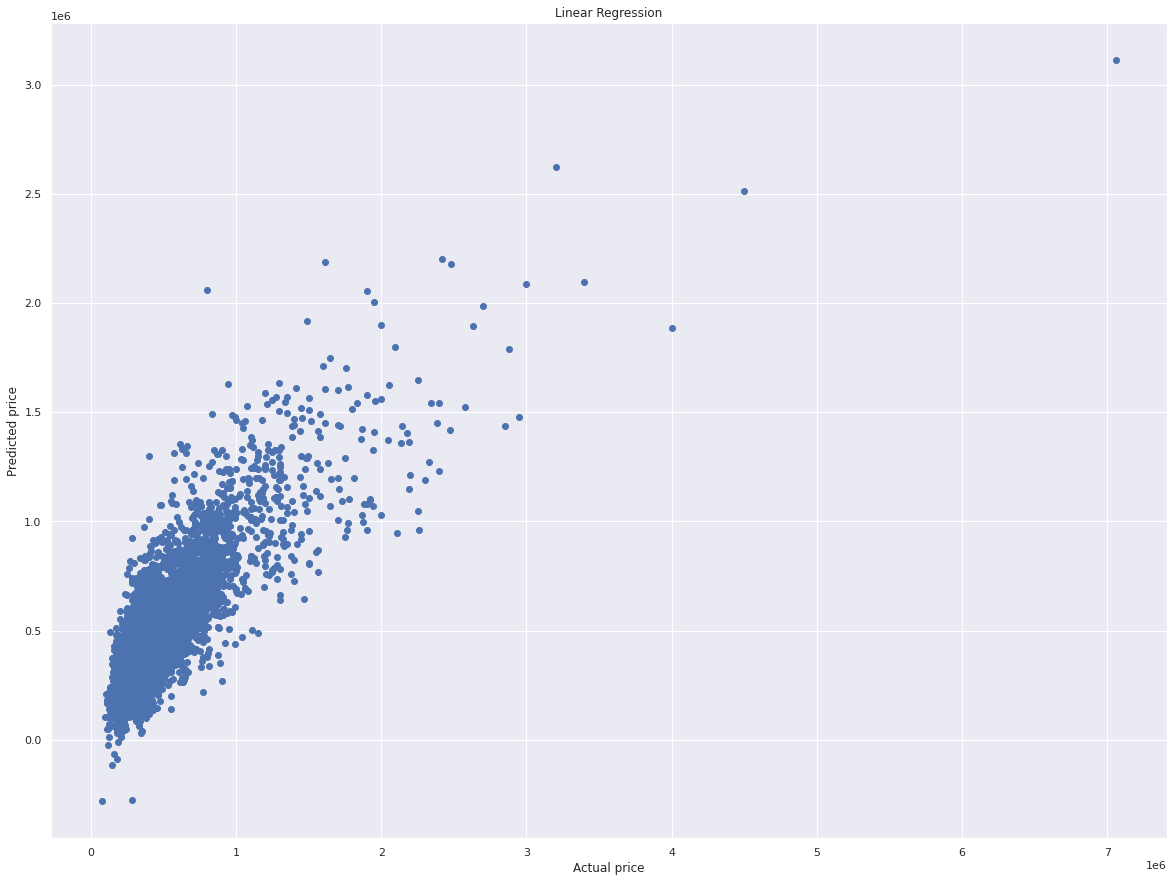

In [60]:
plt.scatter(y_test, y_pred1)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Linear Regression")

Text(0.5, 1.0, 'Xgboost')

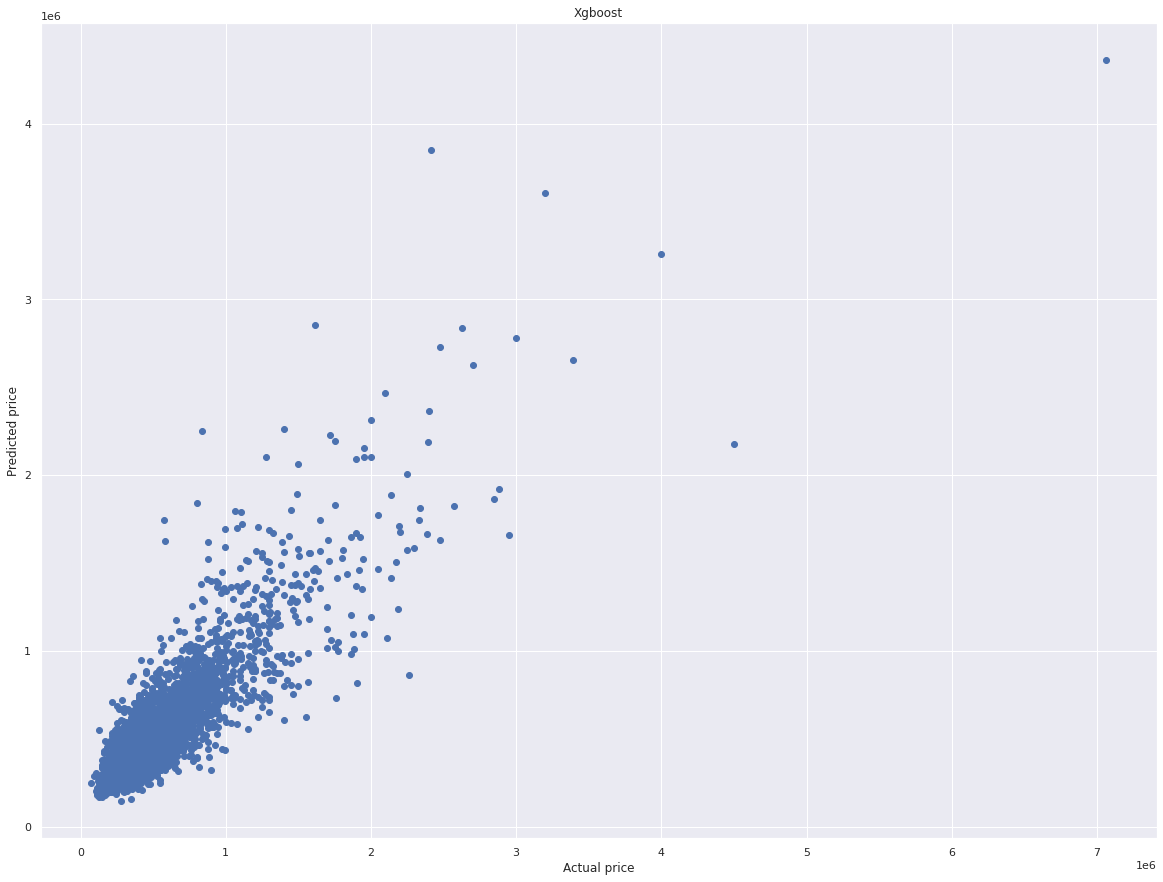

In [31]:
plt.scatter(y_test, y_pred2)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Xgboost")

Text(0.5, 1.0, 'Adaboost')

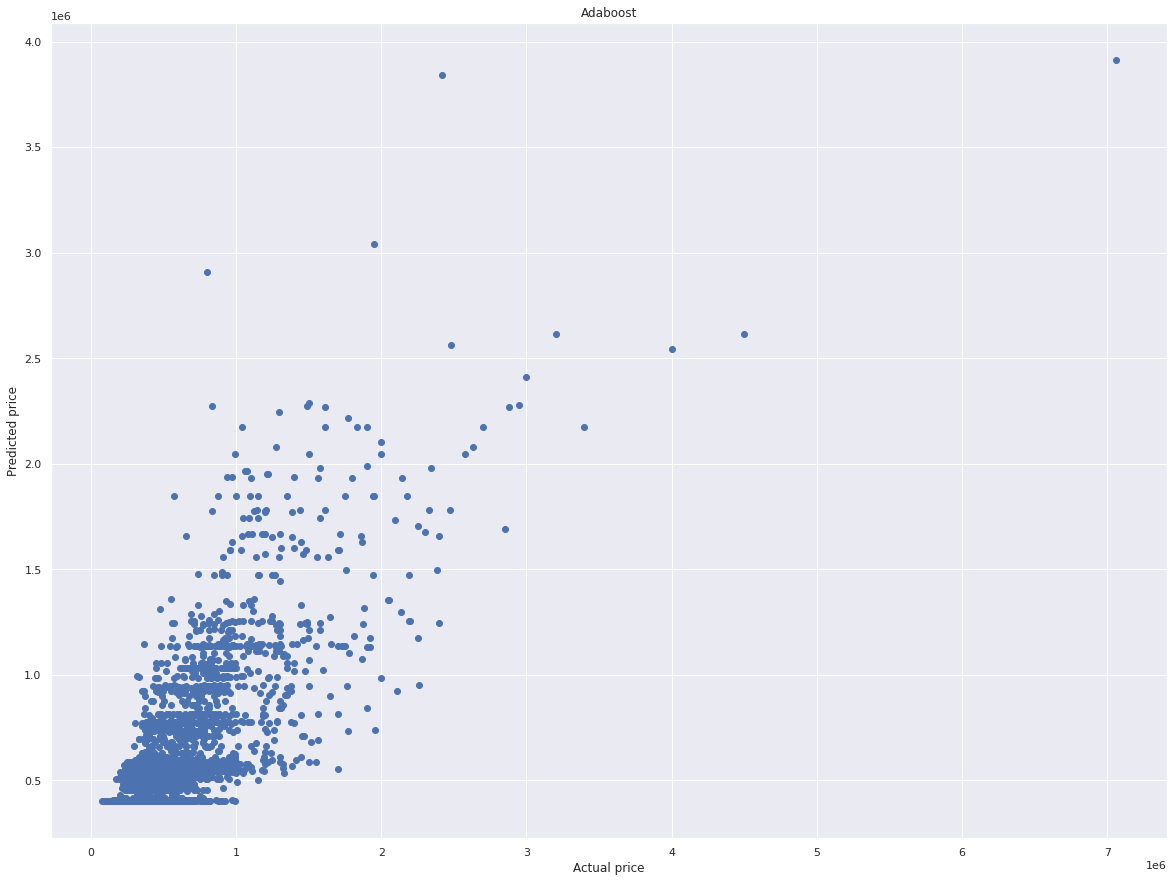

In [32]:
plt.scatter(y_test, y_pred3)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Adaboost")

Text(0.5, 1.0, 'Decision Tree')

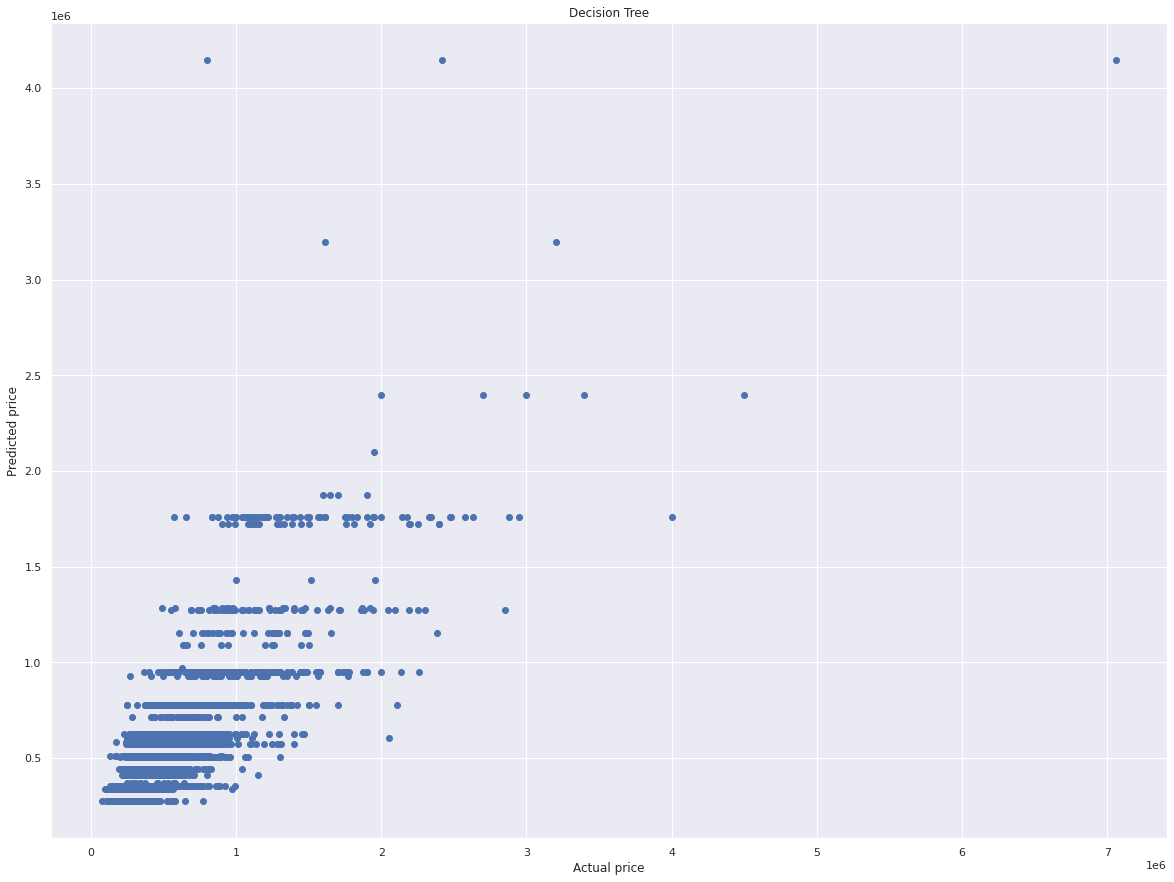

In [33]:
plt.scatter(y_test, y_pred4)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Decision Tree")

Text(0.5, 1.0, 'Random Forest')

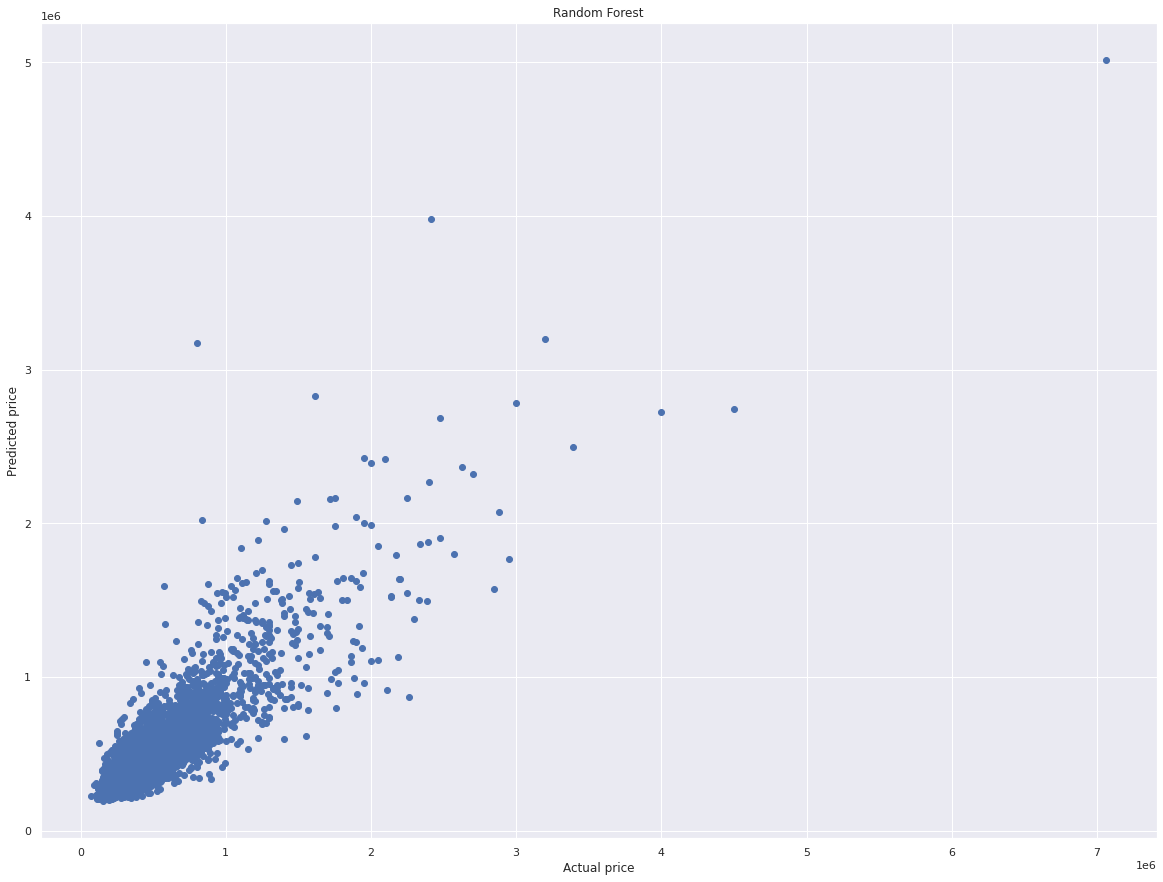

In [34]:
plt.scatter(y_test, y_pred5)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Random Forest")

Text(0.5, 1.0, 'KNN')

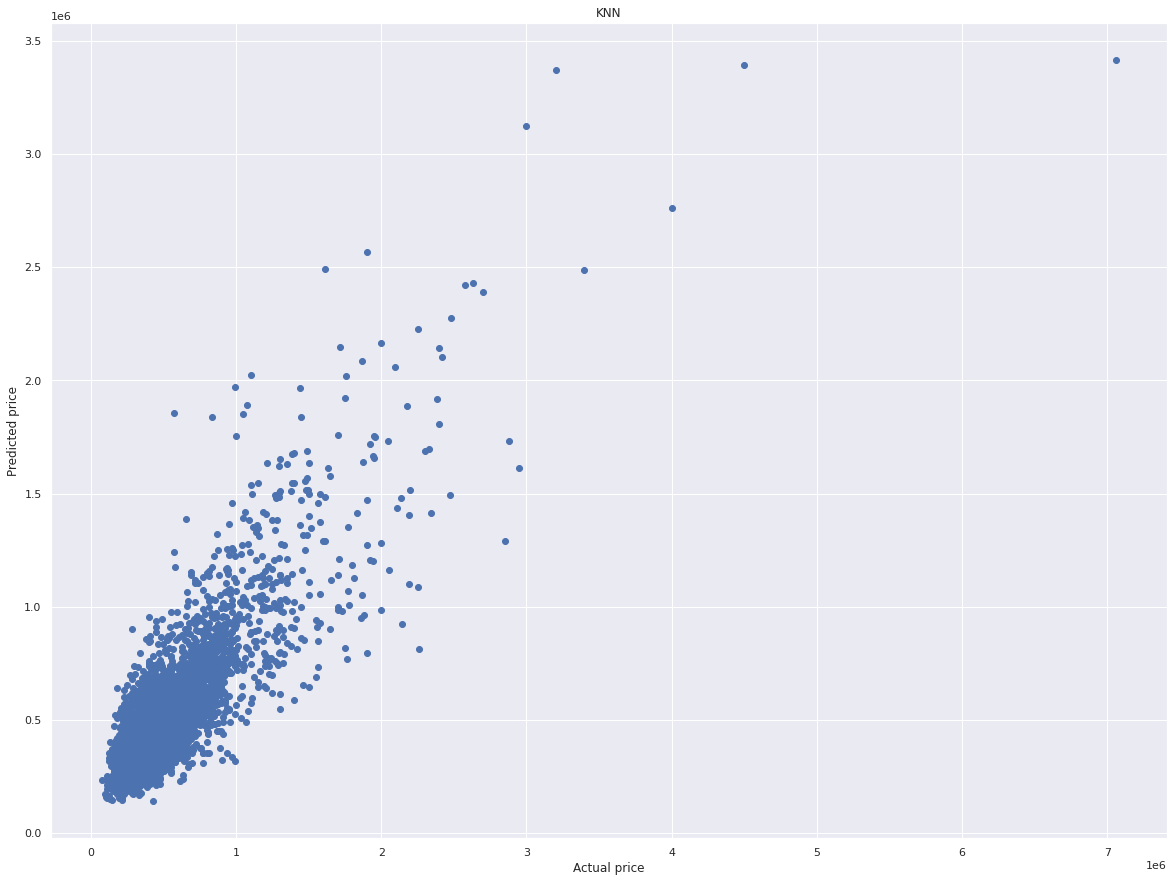

In [35]:
plt.scatter(y_test, y_pred6)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("KNN")

Text(0.5, 1.0, 'SVM')

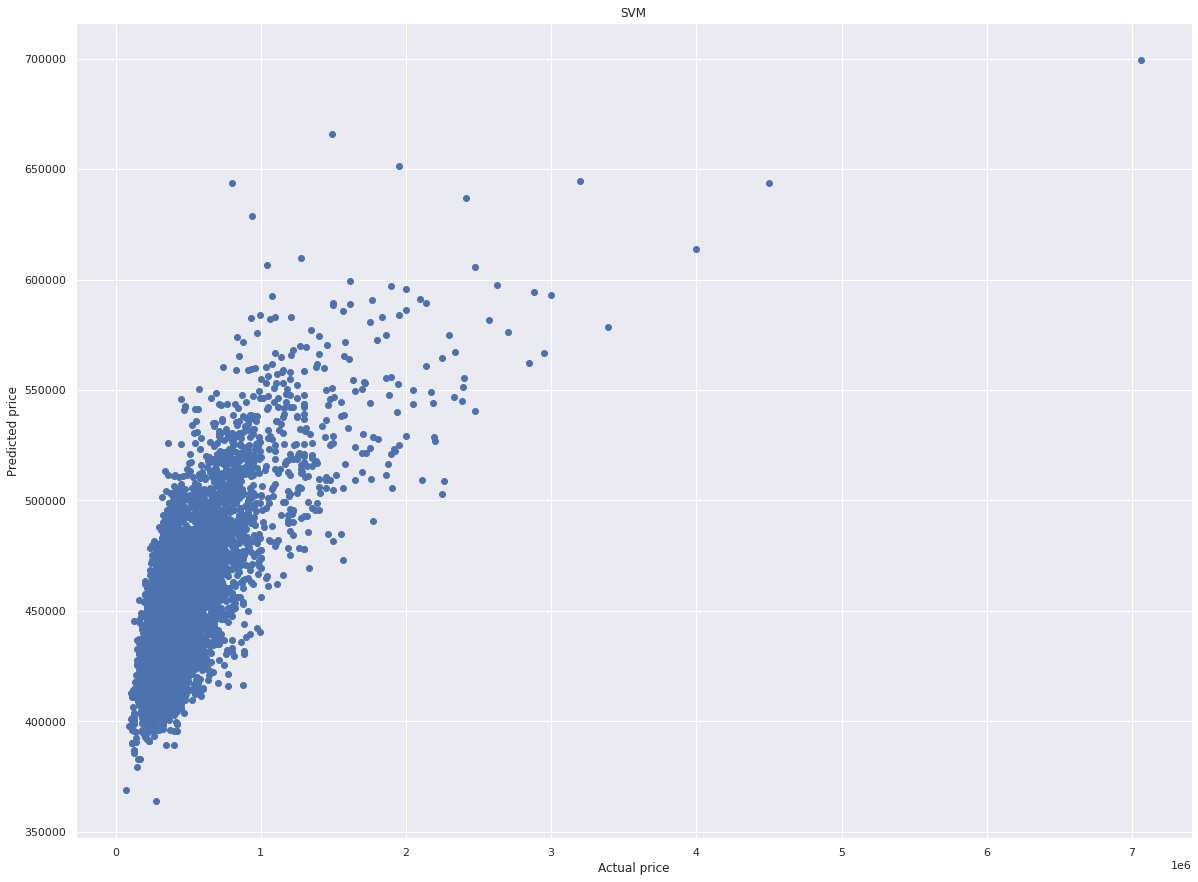

In [36]:
plt.scatter(y_test, y_pred7)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("SVM")

# Creating pipeline

In [51]:
numeric_transformer = Pipeline(
    steps=[
           ('scaler', StandardScaler())
    ]
)

In [52]:
# Creating estimator
regr = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=200, random_state = 0, silent = True)


In [53]:
# Assemble pipeline
main_pipeline = Pipeline(
    steps=[
           ('numeric_transformer', numeric_transformer),
           ('regression', regr)
    ]
)

# Training the model

In [54]:
main_pipeline.fit(X_train, y_train)

Pipeline(steps=[('numeric_transformer',
                 Pipeline(steps=[('scaler', StandardScaler())])),
                ('regression',
                 XGBRegressor(max_depth=5, n_estimators=200, silent=True))])

In [55]:
# Saving the model
import pickle
pickle.dump(main_pipeline, open('kings county price pred pipeline.pkl','wb'))

# Evaluation

In [56]:
#Load the model
import pickle
loaded_model = pickle.load(open("kings county price pred pipeline.pkl","rb"))
#Test out the model using some prediction
y_pred = loaded_model.predict(x_test)

In [31]:
y_pred = main_pipeline.predict(x_test)

In [32]:
import sklearn
sklearn.__version__
#!pip install -U scikit-learn
import sklearn
sklearn.__version__

'0.24.2'

In [57]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

print('MSE                  : ', mean_squared_error(y_test,y_pred))
print('MAE%                 : ',mean_absolute_percentage_error(y_pred, y_test))
print('Median absolute error: ',median_absolute_error(y_test,y_pred))
print('R2 Score             : ',r2_score(y_test,y_pred))

MSE                  :  32375149061.157864
MAE%                 :  0.2152094265897907
Median absolute error:  82063.3125
R2 Score             :  0.7687437454845396


In [58]:
import statsmodels.api as sm
X_1 = sm.add_constant(x_test)
result = sm.OLS(y_test, X_1).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     528.2
Date:                Fri, 23 Jul 2021   Prob (F-statistic):               0.00
Time:                        09:57:26   Log-Likelihood:                -59261.
No. Observations:                4323   AIC:                         1.186e+05
Df Residuals:                    4306   BIC:                         1.187e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6.042e+07   1.43e+07     -4.